In [56]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.datasets import Cityscapes
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [41]:

transform = Compose([
    #Resize((256, 256)),
    ToTensor()
])


target_transform = Compose([
    #Resize((256, 256)),
    ToTensor()
])

dataset = Cityscapes(root="D:\E\CityScapes", split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)

subset_small, subset_big = random_split(dataset, [0.1,0.9])
train_dataset, val_dataset = random_split(subset_small, [0.8,0.2])

In [43]:
val_dataset[0][0].size()

torch.Size([3, 1024, 2048])

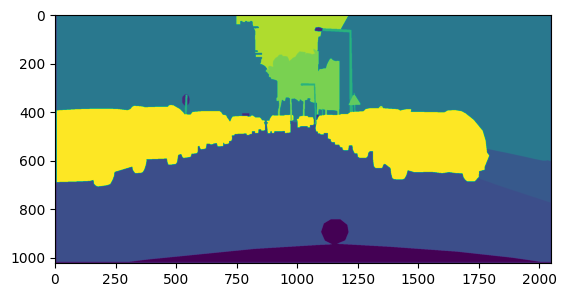

In [66]:
plt.imshow(train_dataset[0][1].numpy().reshape((1024,2048)))

In [52]:
train_dataset[1][1][0][500]#.size()

tensor([0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118])

In [40]:
print(train_dataset[1][1].numpy().reshape((256,256)))

[[0.01176471 0.01568628 0.01568628 ... 0.01176471 0.01176471 0.01176471]
 [0.02745098 0.05882353 0.0627451  ... 0.03529412 0.03529412 0.02352941]
 [0.03529412 0.07843138 0.08235294 ... 0.04313726 0.04313726 0.02745098]
 ...
 [0.01568628 0.02745098 0.02745098 ... 0.02745098 0.02745098 0.01960784]
 [0.01568628 0.02352941 0.02352941 ... 0.02352941 0.02352941 0.01568628]
 [0.01176471 0.01176471 0.01176471 ... 0.01176471 0.01176471 0.01176471]]


In [11]:
batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [12]:

from model import Model

model = Model().cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [36]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Train a model for 1 epoch.

    Params:
    - dataloader:   dataset to train on.
    - model:        the model object to be trained.
    - loss_fn:      the loss function.
    - optimizer:    the desired optimization.
    """
    size = len(dataloader.dataset)
    model.train() #Set the model to train mode
    for batch, (IMG,SEGM) in enumerate(dataloader):
        IMG = IMG.to('cuda')
        SEGM = SEGM.to('cuda')

        
        #predict
        pred = model(IMG)
        plt.imshow(pred.cpu().detach().numpy()[0][3])
        plt.show()
        #Loss
        loss = loss_fn(pred, SEGM)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #print loss during training
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(IMG)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [15]:
def test(dataloader, model, loss_fn):
    """
    Test a model.

    Params:
    - dataloader:   dataset to test on.
    - model:        the model object to be tested.
    - loss_fn:      the loss function.
    """
    num_batches = len(dataloader)
    model.eval() #model in eval mode
    test_loss = 0
    with torch.no_grad():
        for _, (IMG,SEGM) in enumerate(dataloader):
            IMG = IMG.to('cuda')
            SEGM = SEGM.to('cuda')

            pred = model(IMG)
            test_loss += loss_fn(pred, SEGM).item()
            
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


Epoch 1
-------------------------------


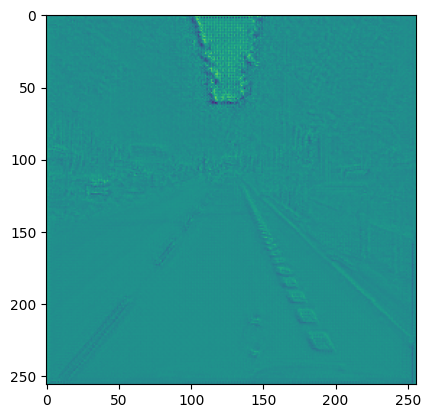

loss: 0.170515  [    8/   37]


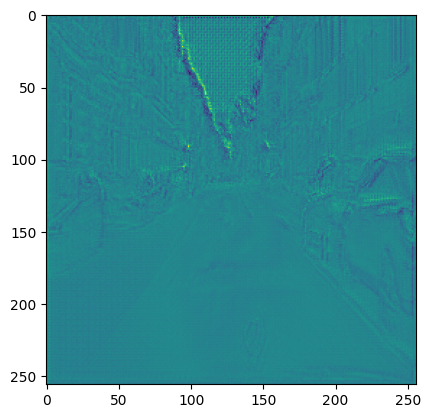

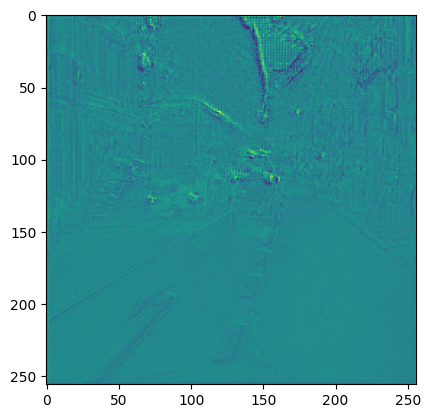

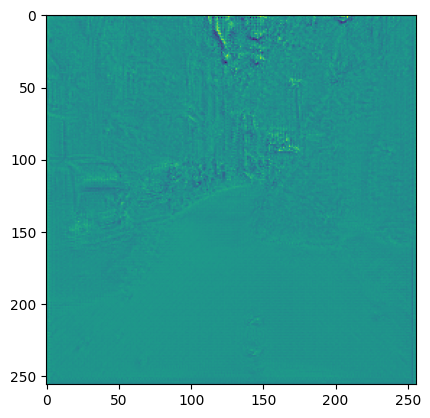

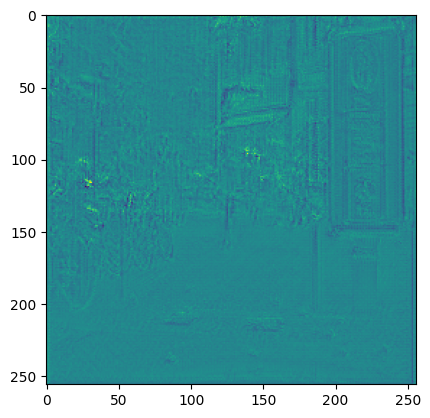

Test Error: 
 Avg loss: 0.035759 

Done!


In [35]:
epochs = 1 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model.eval()
model.to('cpu')
pred = model(subset_big[0][0])

In [ ]:
subset_big[0][0]